In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
data_handlers = {}
for varname in ["u", "v", "s"]:
    dh = DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=False)
    data_handlers[varname] = dh
data_handler = DataHandler.from_several_dhs(data_handlers)
exp = JetFindingExperiment(data_handler)
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = jet_position_as_da(all_jets_one_df, exp.path)
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

In [3]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler.from_specs("ERA5", "plev", varname, "6H", "all", "JJA", -80, 40, 15, 80, [175, 200, 225, 250, 300, 350], reduce_da=True))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    metric=metric,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=50, start_learning_rate=0.05),
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
if not ds_center_path.is_file():
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

In [24]:
# centers_all_jets = find_all_jets(ds_center.load(), basepath=exp_s.path, jet_threshold=0.9e8, wind_threshold=21, alignment_threshold=0.3, mean_alignment_threshold=0.5)
# centers_props_ds_uncat = compute_all_jet_props(centers_all_jets, centers)
# centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)
# props_as_ds_summer = props_as_ds.sel(time=props_as_ds.time.dt.season=="JJA")

No Dask client found, reverting to sequential
Computing jet properties


100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


## Error

In [ ]:
distances = np.zeros(net.n_nodes)
for i in trange(net.n_nodes):
    w = net.weights[i].flatten()[None, :]
    mask = labels.data == i
    x = net.data[mask] .reshape(np.sum(mask), -1) 
    distances[i] = np.mean(pairwise_distances(x, w))

100%|██████████| 24/24 [00:00<00:00, 63.32it/s]


Text(0.5, 1.0, 'Error')

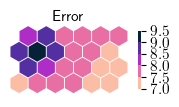

In [ ]:
fig, ax = plt.subplots(figsize=(0.33 * TEXTWIDTH_IN, 1.2), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(7, 10, .5), cmap.N)
fig, ax = net.plot_on_map(distances, fig=fig, ax=ax, cmap=cmap, norm=norm, cmap_kwargs=dict(shrink=1.))
ax.set_title("Error")

## Typical summer pathway

In [4]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.x
    maxdy = net.y
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

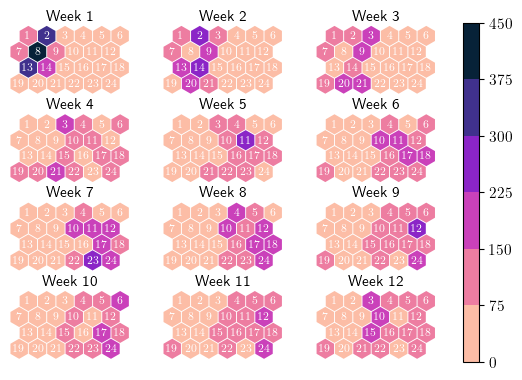

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, 451, 75), cmap.N)
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
fig.colorbar(im, ax=axes)
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="white", fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/som_props/weekly_pathway.png")

In [241]:
coords = net.neighborhoods.coordinates
com_t = np.asarray(list(map(tuple, com)), dtype="f,f")
coords_t = np.asarray(list(map(tuple, coords)), dtype="f,f")

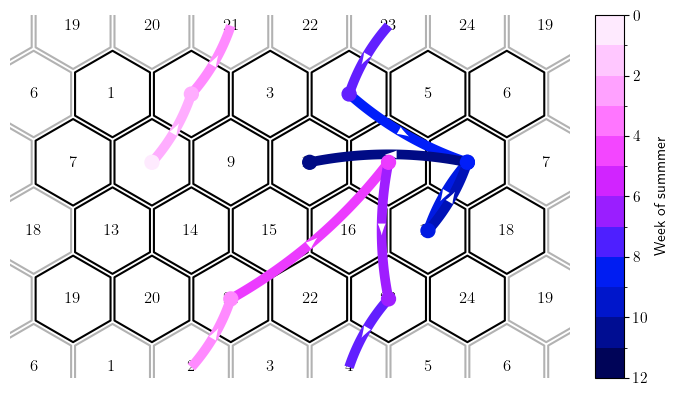

In [15]:
from simpsom.plots import create_outer_grid, traj_to_segments, segments_to_arcs, plot_map
from matplotlib.collections import PatchCollection, LineCollection

outer_grid, inner_grid, coords, outermask = create_outer_grid(net.width, net.height)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = "black"
alphas = np.ones(len(coords))
alphas[outermask] = 0.3

traj = []
for step_ in timestepwise:
    unique, counts = step_[2:]
    traj.append(unique[np.argmax(counts)])
traj = np.asarray(traj)   
# traj = np.argmin(pairwise_distances(com, net.neighborhoods.coordinates), axis=1) 
traj_split = np.split(traj, np.where((np.diff(traj) != 0))[0] + 1)
sizes = np.asarray([len(stay) for stay in traj_split])
uniques = np.asarray([stay[0] for stay in traj_split])
color_array = np.asarray([0, *np.cumsum(sizes)], dtype=int)
cmap = colormaps.cet_l_bmw1_r
colors = cmap(np.linspace(0, 1, len(traj) + 1))[color_array]
sort_like = np.argsort(sizes)[::-1]
    
segments, reps = traj_to_segments(traj_split, coords, outer_grid, outermask)
arcs, arrows = segments_to_arcs(segments)

gs = plt.GridSpec(
    1,
    3,
    width_ratios=[1, 0.02, 0.05],
    wspace=0.01,
    left=0.01,
    right=0.9,
    bottom=0.01,
    top=0.99,
)
fig = plt.figure(figsize=(TEXTWIDTH_IN, 3.7))
ax = fig.add_subplot(gs[0], aspect="equal")
ax_cbar = fig.add_subplot(gs[2])
inner_coords = coords[~outermask]
xlims = [
    np.amin(inner_coords[:, 0]) - 0.8,
    np.amax(inner_coords[:, 0]) + 0.8,
]
ylims = [
    np.amin(inner_coords[:, 1]) - 1,
    np.amax(inner_coords[:, 1]) + 1,
]

fig, ax = plot_map(
    coords,
    np.zeros(len(coords)) + np.nan,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors=edgecolors,
    alphas=alphas,
    linewidths=1.5,
    fig=fig,
    ax=ax,
)
for i, c in enumerate(coords):
    x, y = c
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${to_prettier_order(outer_grid.flatten()[i])}$', va='center', ha='center', color="black", fontsize=15)
lc = LineCollection(arcs, colors=np.repeat(colors[1:-1], reps, axis=0), zorder=3)
lc.set_linewidth(7)
lc = ax.add_collection(lc)
arrows = PatchCollection(arrows, zorder=9, edgecolor=None, facecolor="white")
ax.add_collection(arrows)
im = ScalarMappable(BoundaryNorm(np.arange(0, len(traj)), cmap.N), cmap)
cbar = fig.colorbar(
    im,
    cax=ax_cbar,
    label="Week of summmer"
)
uniques = uniques[sort_like]
sizes = sizes[sort_like]
colors = colors[:-1][sort_like]
ax.scatter(*coords[~outermask][uniques].T, s=100, c=colors, zorder=10)
colors = cmap(np.linspace(0, 1, len(com)))
# for color, com_, com_std_ in zip(colors, com, com_std):
#     com_ = com_ + np.asarray([ 4., 3.4641 ])
#     ax.errorbar(*com_, *com_std_[[1, 0]], zorder=10, color=color)
ax_cbar.invert_yaxis()
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.savefig(f"{FIGURES}/som_props/track_com.png")

## DST

In [ ]:
from CDSK import dynamical_local_indexes
X, da = exp_s.prepare_for_clustering()
X = exp_s.pca_transform(X, 100)
ld, theta, alpha = dynamical_local_indexes(X, n_jobs=10)
np.save(exp_s.path.joinpath("ld_100"), ld.squeeze())
np.save(exp_s.path.joinpath("theta_100"), theta.squeeze())

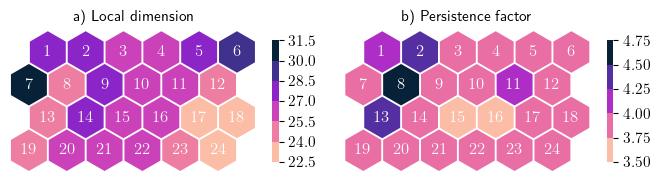

In [45]:
ld = np.load(exp_s.path.joinpath("ld_100.npy"))
theta = np.load(exp_s.path.joinpath("theta_100.npy"))

to_plot_ld = timeseries_on_map(ld, net.bmus)[0]
to_plot_theta = timeseries_on_map(1 / theta, net.bmus)[0]

cmap = colormaps.bubblegum_r
fig, axes = plt.subplots(1, 2, figsize=(1. * TEXTWIDTH_IN, 2), tight_layout=False, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_ld,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Local dimension")
fig, axes[1] = net.plot_on_map(
    to_plot_theta,
    smooth_sigma=0,
    fig=fig,
    cmap=cmap,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) Persistence factor")
coords = net.neighborhoods.coordinates
for i, c in enumerate(coords):
    x, y = c
    for ax in axes:
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/DST.png')

## pops, stats

In [36]:
da = exp_s.da
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )


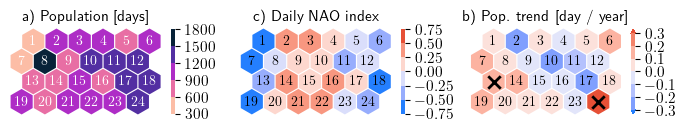

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.46), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Population [days]", pad=2)
cmap = colormaps.cet_d_bwr
fig, axes[2] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    norm=BoundaryNorm(np.linspace(-0.3, 0.3, 7), cmap.N, extend="both"),
    fig=fig,
    ax=axes[2],
)
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
# axes[2].scatter(*coords.T, s=260, edgecolors="black", marker="h", linewidths=1., facecolors="none")
axes[2].scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
axes[2].set_title("b) Pop. trend [day / year]", pad=2)
fig, axes[1] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1],
    cmap=cmap,
    # discretify=True,
    norm=BoundaryNorm(np.linspace(-0.75, 0.75, 7), cmap.N)
)
axes[1].set_title("c) Daily NAO index", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j == 0 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/pop_nao_trend.png')

## PVs

In [67]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da

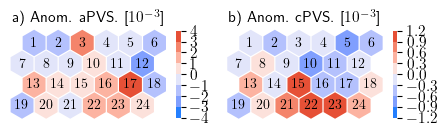

In [68]:
time_mask = np.isin(labels.time.values, da_pvs.time.values)
to_plot_anti = np.asarray([da_pvs.loc[:, 'anti'][mask_[time_mask]].mean().item() for mask_ in mask.T])
to_plot_cycl = np.asarray([da_pvs.loc[:, 'cycl'][mask_[time_mask]].mean().item() for mask_ in mask.T])

fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.5), tight_layout=True, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_anti * 1000,
    smooth_sigma=0,
    show=False,
    cmap=colormaps.cet_d_bwr,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title(r"a) Anom. aPVS. [$10^{-3}$]", pad=2)
fig, axes[1] = net.plot_on_map(
    to_plot_cycl * 1000,
    smooth_sigma=0,
    fig=fig,
    cmap=colormaps.cet_d_bwr,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title(r"b) Anom. cPVS. [$10^{-3}$]", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="black", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/PVS_activity.png')

## rt, $\sigma=0$

In [8]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(0, yearbreak=yearbreak, q=0.95)

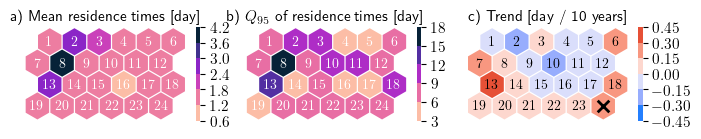

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence.png')

## rt, $\sigma=1$

In [10]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(1, yearbreak=yearbreak)

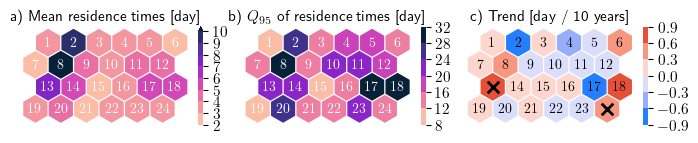

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    norm=BoundaryNorm([2, 3, 4, 5, 6, 7, 8, 9, 10], cmap.N, extend="max"),
    # discretify=True,
    cbar_kwargs=dict(shrink=0.85, spacing="proportional")
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence_sigma1.png')

## lagged backwards diffusion

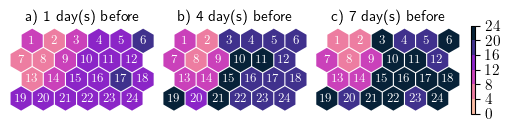

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
for step, ax, letter in zip(steps, axes, ["a", "b", "c"]):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=0)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/dilution_before.png')

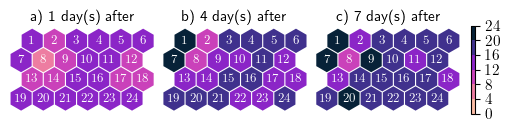

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
for step, ax, letter in zip(steps, axes, ["a", "b", "c"]):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=1)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/dilution_after.png')

## lagged backwards transitions

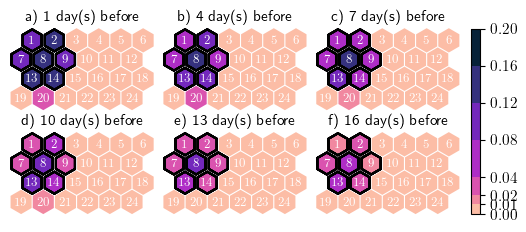

In [79]:
fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 2.1), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
norm = BoundaryNorm([0, 0.01, 0.02, 0.04, 0.08, 0.12, 0.16, 0.2], cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional", shrink=0.9, pad=0.02)
to_ = [1, 2, 3, 5, 6, 7, 10]
coords = net.neighborhoods.coordinates
coords_subset = net.neighborhoods.coordinates[to_]
for i, (ax, letter) in enumerate(zip(axes.ravel(), list("abcdef"))):
    step = 4 + 12 * i
    transmat = np.mean(net.compute_transmat(step=step, yearbreaks=yearbreak)[:, to_], axis=1)
    fig, ax = net.plot_on_map(
        transmat,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    )
    for j in to_:
        ax.scatter(*coords_subset.T, s=250, edgecolors="black", marker="h", linewidths=1.5, facecolors="none")
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
plt.savefig(f'{FIGURES}/som_props/lagged_transition_subspace.png')

## Back and forward mean distance

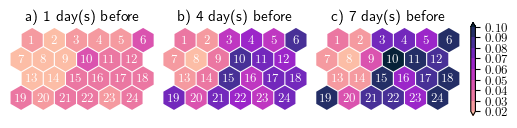

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0.02, 0.11, 0.01), cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
cbar = fig.colorbar(im, ax=axes, pad=0.02, shrink=0.95)
cbar.ax.tick_params(labelsize=9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, col in enumerate(transmat.T):
        mean_dists[node] = np.mean(col * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_before.png')

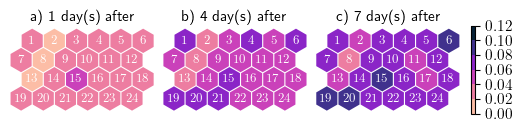

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0.02, 0.11, 0.01), cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, line in enumerate(transmat):
        mean_dists[node] = np.mean(line * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=9)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_after.png')

## jet indices

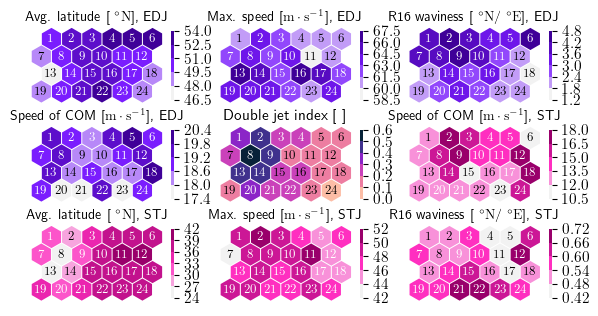

In [33]:
data_vars_and_jets = [
    ("mean_lat", "polar"),
    ("spe_star", "polar"),
    ("wavinessR16", "polar"),
    ("com_speed", "polar"),
    ("double_jet_index", "_"),
    ("com_speed", "subtropical"),
    ("mean_lat", "subtropical"),
    ("spe_star", "subtropical"),
    ("wavinessR16", "subtropical"),
]
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for (varname, jet), (j, ax) in zip(data_vars_and_jets, enumerate(axes)):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
        cmap = MYPURPLES if jet == "polar" else MYPINKS
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {SHORTHAND[jet]}", pad=2, fontsize=10)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
        cmap = colormaps.bubblegum_r
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        cbar_kwargs=dict(shrink=0.8)
    )
    norm = BoundaryNorm(MaxNLocator(7).tick_values(np.amin(to_plot), np.amax(to_plot)), cmap.N)
    for i, c in enumerate(coords):
        darkness = norm(to_plot[i]) / cmap.N
        x, y = c
        # color = "white" if j == 4 else "black"
        color = "white" if darkness > 0.3 else "black"
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=9)
fig.savefig(f'{FIGURES}/som_props/combined_indices.png')

In [32]:
darkness

0.7109375

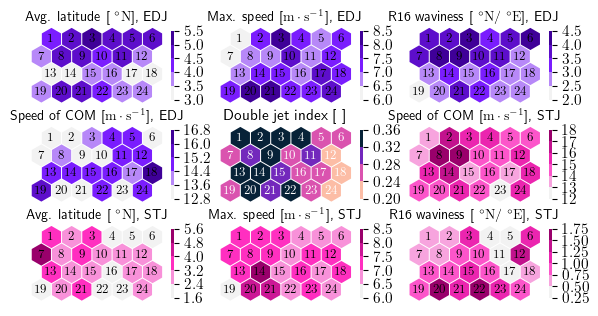

: 

In [12]:
def std_on_map(timeseries, labels):
    timeseries = np.atleast_2d(timeseries)
    mask = labels_to_mask(labels)
    return np.asarray(
        [[np.nanstd(timeseries_[mas]) for mas in mask.T] for timeseries_ in timeseries]
    )
data_vars_and_jets = [
    ("mean_lat", "polar"),
    ("spe_star", "polar"),
    ("wavinessR16", "polar"),
    ("com_speed", "polar"),
    ("double_jet_index", "_"),
    ("com_speed", "subtropical"),
    ("mean_lat", "subtropical"),
    ("spe_star", "subtropical"),
    ("wavinessR16", "subtropical"),
]
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for (varname, jet), ax in zip(data_vars_and_jets, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
        cmap = MYPURPLES if jet == "polar" else MYPINKS
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {SHORTHAND[jet]}", pad=2, fontsize=10)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
        cmap = colormaps.bubblegum_r
        ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot = std_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        cbar_kwargs=dict(shrink=0.8)
    )
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes.ravel()):
        color = "white" if j == 4 else "black" 
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color=color, fontsize=9)
fig.savefig(f'{FIGURES}/som_props/combined_indices_stds.png')

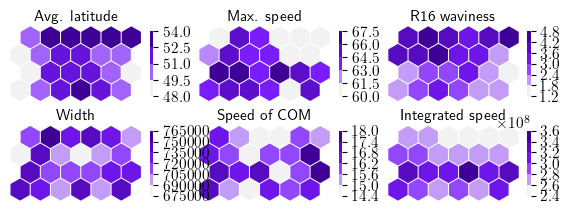

In [27]:
data_vars = ["mean_lat", "Spe", "sinuosity3", "width", "com_speed", "int"]
jet = "polar"

fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 1.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for varname, ax in zip(data_vars, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=MYPURPLES,
        discretify=True,
        cbar_kwargs=dict(shrink=0.75)
    )
    ax.set_title(f"{PRETTIER_VARNAME[varname]}", pad=2)
    # ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
fig.savefig(f'{FIGURES}/som_props/polar_indices.png')

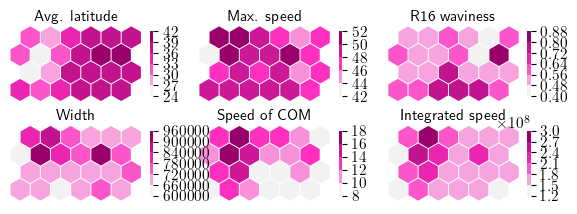

In [28]:
data_vars = ["mean_lat", "Spe", "sinuosity3", "width", "com_speed", "int"]
jet = "subtropical"

fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN, 1.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes = axes.flatten()
for varname, ax in zip(data_vars, axes):
    try:
        to_plot = props_as_ds_summer[varname].sel(jet=jet)
    except KeyError:
        to_plot = props_as_ds_summer[varname]
    to_plot = timeseries_on_map(to_plot, net.bmus)[0]
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=MYPINKS,
        discretify=True,
        cbar_kwargs=dict(shrink=0.75)
    )
    ax.set_title(f"{PRETTIER_VARNAME[varname]}", pad=2)
    # ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]")
fig.savefig(f'{FIGURES}/som_props/subtropical_indices.png')

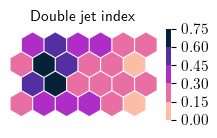

In [29]:
varname = "double_jet_index"
cmap = colormaps.bubblegum_r

fig, ax = plt.subplots(1, 1, figsize=(0.33 * TEXTWIDTH_IN, 1.5), tight_layout=True, sharex="all", subplot_kw=dict(aspect="equal"))
to_plot = props_as_ds_summer[varname]
to_plot = timeseries_on_map(to_plot, net.bmus)[0]
fig, ax = net.plot_on_map(
    to_plot,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=True,
    cmap=cmap,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
ax.set_title(f"{PRETTIER_VARNAME[varname]}")
fig.savefig(f'{FIGURES}/som_props/double_jet_index.png')